# Определение наличия турбонаддува в автомобилях 
В данном проекте с помощью методов машинного обучения произведена попытка предсказания наличия турбонаддува в автомобиле по другим характеристикам, а именно:
- body (кузов)
- myear (год производства)
- transmission (тип трансмиссии)
- Drive Type (тип привода)
- fuel (тип топлива)
- oem (марка автомобиля)
- No of Cylinder (количество цилиндров)
- Color (цвет автомобиля)
- Valve Configuration (расположение клапанов двигателя)
- Top Speed (максимальная скорость

Для данного проекта был взят датасет "Used Cars Dataset (CarDekho)". Ссылка на датасет: https://www.kaggle.com/datasets/sukritchatterjee/used-cars-dataset-cardekho

# Этап №1. Получение и предобработка данных


Для начала работы необходимо импортировать все необходимые библиотеки:

In [224]:
# working with data
import pandas as pd
import numpy as np

# data analysis
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# prepare data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Для работы будут использованы следующие библиотеки: 
- Pandas - для работы с данными в наиболее удобном формате DataFrame
- NumPy - для числовых операций
- matplotlib - для визуализации данных выборки и построения графиков результатов
- seaborn - для визуализации матрицы ошибок
- time - для получения времени, затраченного на работу моделей 
- scikit-learn - для подключения и использования моделей 

Далее считаем данные из датасета и посмотрим на его размеры:

In [225]:
df = pd.read_csv("cars_data_clean.csv")
df.shape

(37813, 66)

Видим что датасет содержит 37813 строк и 66 колонок. Получим список всех столбцов:

In [226]:
df.columns

Index(['usedCarSkuId', 'loc', 'myear', 'body', 'transmission', 'fuel', 'km',
       'ip', 'images', 'imgCount', 'threesixty', 'dvn', 'oem', 'model',
       'variant', 'City', 'listed_price', 'discountValue', 'utype', 'carType',
       'top_features', 'comfort_features', 'interior_features',
       'exterior_features', 'safety_features', 'Color', 'Engine Type',
       'No of Cylinder', 'Valves per Cylinder', 'Valve Configuration',
       'Turbo Charger', 'Super Charger', 'Length', 'Width', 'Height',
       'Wheel Base', 'Front Tread', 'Rear Tread', 'Kerb Weight',
       'Gross Weight', 'Gear Box', 'Drive Type', 'Seats', 'Steering Type',
       'Turning Radius', 'Front Brake Type', 'Rear Brake Type', 'Top Speed',
       'Acceleration', 'Tyre Type', 'Doors', 'Cargo Volume', 'model_type_new',
       'state', 'exterior_color', 'owner_type', 'Fuel Suppy System',
       'Compression Ratio', 'Alloy Wheel Size', 'Ground Clearance Unladen',
       'Max Power Delivered', 'Max Power At', 'Max Torq

Оставим лишь необходимые для работы колонки и посмотрим на то, как выглядит датасет с помощью команды df.head(), которая по умолчанию выводит первые 5 записей, но в качестве параметра может принимать и другое количество строк для вывода.

In [227]:
df = df[[
    "body",
    "myear",
    "transmission",
    "Drive Type",
    "fuel",
    "oem",
    "No of Cylinder",
    "Color",
    "Valve Configuration",
    "Top Speed",
    "Turbo Charger",
]]
df.head()
df.isnull().sum()

body                      19
myear                      0
transmission               0
Drive Type              4497
fuel                       0
oem                        0
No of Cylinder           143
Color                    160
Valve Configuration     7962
Top Speed              15352
Turbo Charger              0
dtype: int64

Переименуем колонки в более понятные и корректные обозначения. Для этого используем метод df.rename()

In [228]:
df = df.rename(columns={
    "body": "BodyType",
    "myear": "ModelYear",
    "transmission": "TransmissionType",
    "Drive Type": "DriveType",
    "fuel": "FuelType",
    "oem": "Brand",
    "No of Cylinder": "CylinderNumber",
    "Turbo Charger": "TurboCharger",
    "Valve Configuration": "ValveConfiguration",
    "Top Speed": "TopSpeed"
})
df.head()

,BodyType,ModelYear,TransmissionType,DriveType,FuelType,Brand,CylinderNumber,Color,ValveConfiguration,TopSpeed,TurboCharger
0,hatchback,2016,manual,fwd,cng,maruti,3.0,silver,dohc,137.0,False
1,hatchback,2015,manual,fwd,cng,maruti,3.0,grey,dohc,150.0,False
2,sedan,2015,manual,fwd,cng,honda,4.0,silver,sohc,160.0,False
3,hatchback,2013,manual,fwd,cng,maruti,3.0,silver,NaN,NaN,False
4,muv,2022,manual,2wd,cng,maruti,4.0,white,NaN,NaN,True


Создадим функцию, которая будет заменять все строковые значения на числовые, чтобы с ними было возможно работать при обработке данных. Данная функция принимает название колонки, считает количество уникальных значений в данной колонке датасета, затем составляет словарь, где для каждого из уникальных значений сопоставляется число. По итогу данные в датасете заменяются на числовые с помощью df.replace().

In [229]:
def change_to_nums(column: str):
    unique_values = df[column].unique()
    new_values = {
        column: {}
    }
    for i in range(len(unique_values)):
        if unique_values[i] is not None:
            new_values[column][unique_values[i]] = int(i)
    df.replace(new_values, inplace=True)

Применим эту функцию ко всем колонкам с нечисловыми значениями.

In [230]:
for column in [
    "BodyType",
    "TransmissionType",
    "FuelType",
    "Brand",
    "CylinderNumber",
    "TurboCharger",
    "Color",
    "ValveConfiguration"
]:
    change_to_nums(column)

C:\Users\Arseniy\AppData\Local\Temp\ipykernel_10296\3435793741.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(new_values, inplace=True)


Для колонки с типом привода данный подход не подойдет - одни и те же значения (например, All Wheels Drive и 4 Wheels Drive) записаны по-разному и будут считаться как разные, хотя на самом деле представляют одно и то же значение. Поэтому необходимо выполнить замену вручную.

In [231]:
new_drive_type_values = {
    "DriveType":
        {
            "fwd": 0,
            "rwd": 1,
            "awd": 2,
            "4wd": 2,
            "2wd": 0,
            "4x2": 0
        }}
df.replace(new_drive_type_values, inplace=True)

C:\Users\Arseniy\AppData\Local\Temp\ipykernel_10296\3598524929.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(new_drive_type_values, inplace=True)


Посмотрим на то, как выглядит таблица после произведённых преобразований:

In [232]:
df.head()

,BodyType,ModelYear,TransmissionType,DriveType,FuelType,Brand,CylinderNumber,Color,ValveConfiguration,TopSpeed,TurboCharger
0,0,2016,0,0.0,0,0,0.0,0,0,137.0,0
1,0,2015,0,0.0,0,0,0.0,1,0,150.0,0
2,1,2015,0,0.0,0,1,1.0,0,1,160.0,0
3,0,2013,0,0.0,0,0,0.0,0,2,NaN,0
4,2,2022,0,0.0,0,0,1.0,2,2,NaN,1


Посмотрим, сколько нулевых значений имеется в каждой из колонок:

In [233]:
df.isnull().sum()

BodyType                  0
ModelYear                 0
TransmissionType          0
DriveType              4497
FuelType                  0
Brand                     0
CylinderNumber            0
Color                     0
ValveConfiguration        0
TopSpeed              15352
TurboCharger              0
dtype: int64

В колонках "DriveType" и "TopSpeed" имеется достаточно много записей с пустыми значениями (NaN). Чтобы не удалять эти данные, используем один из самых популярных методов работы с пустыми значениями: заменим их на среднее по столбцу и приведём весь датасет к целочисленному типу. Для этого используем 2 функции:
- df.fillna - для заполнения пустых значений
- df.astype - для приведения к типу Int 

In [234]:
df.fillna(df.mean(), inplace=True)
df = df.astype(int)
df.head()

,BodyType,ModelYear,TransmissionType,DriveType,FuelType,Brand,CylinderNumber,Color,ValveConfiguration,TopSpeed,TurboCharger
0,0,2016,0,0,0,0,0,0,0,137,0
1,0,2015,0,0,0,0,0,1,0,150,0
2,1,2015,0,0,0,1,1,0,1,160,0
3,0,2013,0,0,0,0,0,0,2,172,0
4,2,2022,0,0,0,0,1,2,2,172,1


# Этап №2. Поиск выбросов

Поиск выбросов - один из важнейших этапов работы с данными. Удаление значений, которые встречаются слишком редко или логически не подходят под условие задачи (например, если максимальная скорость бега человека составляет 300 км/час) позволяет достичь более высоких показателей при работе моделей. 

Для начала оценим распределение значений по типу кузова (BodyType).

## 2.1 Проверка выбросов BodyType
Для начала оценим распределение значений по типу кузова (BodyType).

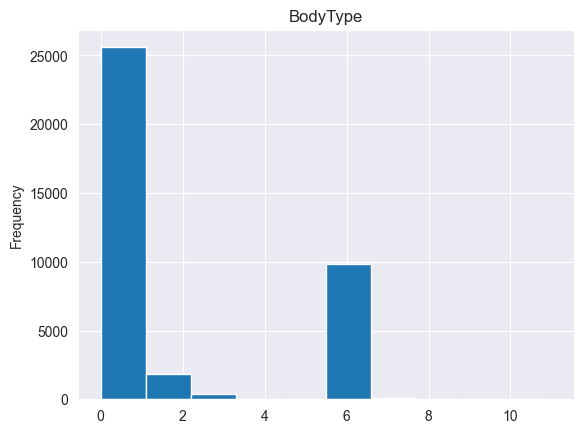

In [235]:
df.BodyType.plot(kind="hist")
plt.title("BodyType")
plt.show()

Видим, что из всех значений, содержащих 12 уникальных видов, можно оставить лишь значения, где BodyType принадлежит множеству (0, 1, 2, 6).

In [236]:
df = df[(df.BodyType == 0) | (df.BodyType == 1) | (df.BodyType == 2) | (df.BodyType == 6)]
df.shape

(37230, 11)

Таким образом, было удалено 583 записи из датасета. 

## 2.2 Проверка выбросов ModelYear
Далее перейдем к году выпуска автомобиля и построим ящик с усами:

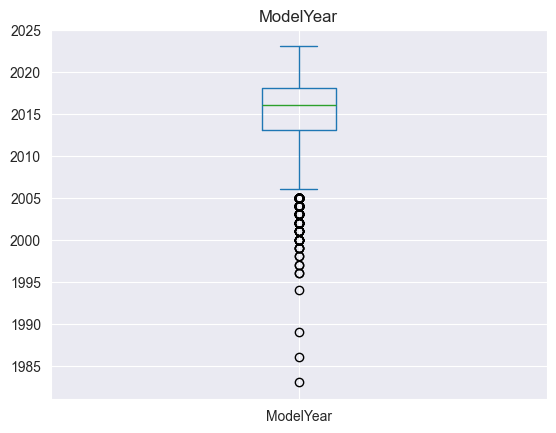

In [237]:
df.ModelYear.plot(kind="box")
plt.title("ModelYear")
plt.show()

Сделаем выборку чуть меньше, чтобы понять с какого года данные можно отбрасывать:

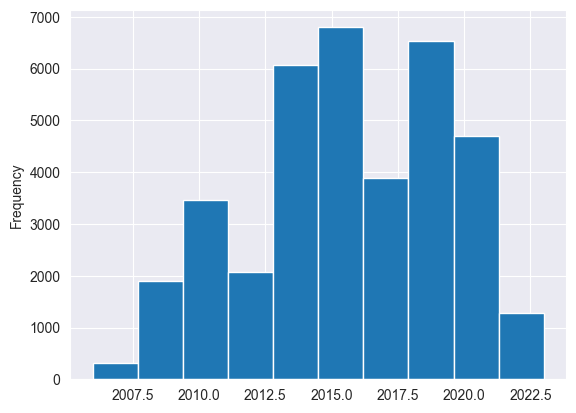

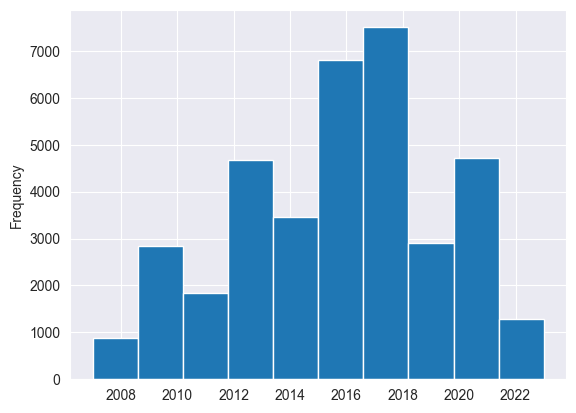

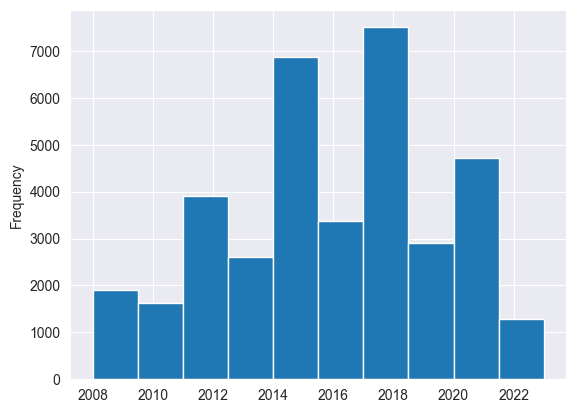

In [238]:
df[df.ModelYear > 2005].ModelYear.plot(kind="hist")
plt.show()
df[df.ModelYear > 2006].ModelYear.plot(kind="hist")
plt.show()
df[df.ModelYear > 2007].ModelYear.plot(kind="hist")
plt.show()

Остановимся на том, что отбросим записи, где год выпуска раньше 2008.

In [239]:
df = df[df.ModelYear > 2007]
df.shape

(36702, 11)

На данном этапе было удалено еще 528 лишних значений, без которых работа с моделями должна получиться более продуктивной. 

## 2.3 Проверка выбросов TransmissionType
Перейдём к оценке типа трансмиссии. Данный столбец должен быть бинарным и содержать лишь значения 0 и 1. Для проверки этого воспользуемся круговой диаграммой.

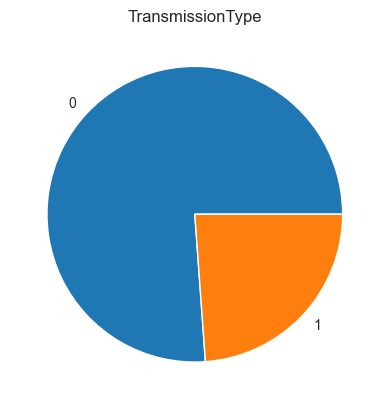

In [240]:
plt.pie(
    df.TransmissionType.value_counts().values,
    labels=df.TransmissionType.value_counts().index
)
plt.title("TransmissionType")
plt.show()

Видим, что наша круговая диаграмма содержит 2 вида значений: 0 и 1, что означает, что в данном столбце выбросов не обнаружено.

## 2.4 Проверка выбросов FuelType
Далее также с помощью круговой диаграммы проверим на наличие выбросов столбец с типом топлива.

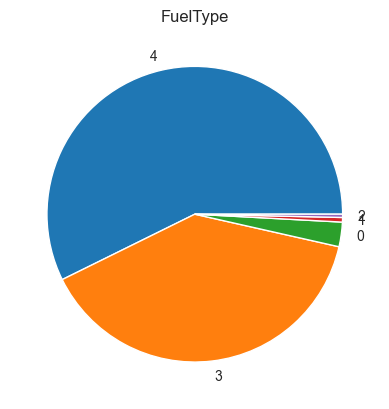

In [241]:
plt.pie(
    df.FuelType.value_counts().values,
    labels=df.FuelType.value_counts().index
)
plt.title("FuelType")
plt.show()

Видим, что значительную часть занимают данные, где тип топлива принимает значения 3 и 4. Значит, от остальных значений можно избавиться

In [242]:
df = df[df.FuelType > 2]
df.shape

(35405, 11)

## 2.5 Проверка выбросов DriveType
Далее аналогичным способом рассмотрим тип привода.

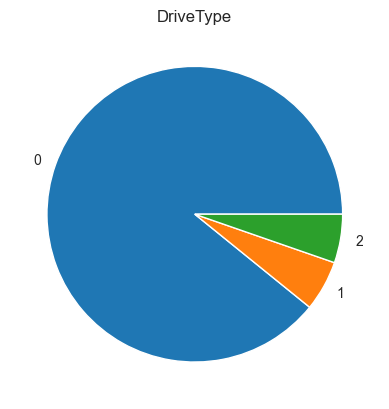

In [243]:
plt.pie(
    df.DriveType.value_counts().values,
    labels=df.DriveType.value_counts().index
)
plt.title("DriveType")
plt.show()

Здесь также выбросов не обнаружено: все данные логически подходят под условия и ни одна из категорий не содержит слишком мало значений. Перейдем к оценке выбросов по производителю автомобилей.

## 2.6 Проверка выбросов Brand

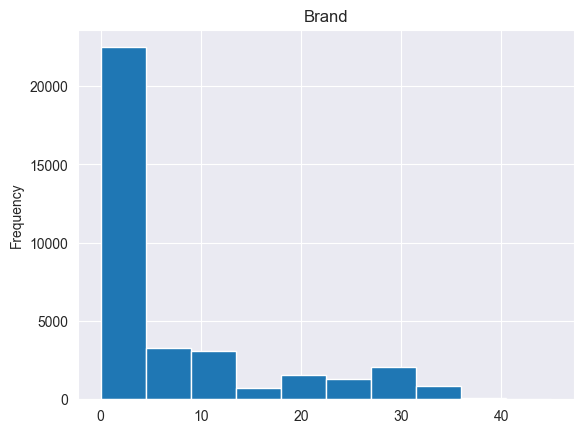

In [244]:
df.Brand.plot(kind="hist")
plt.title("Brand")
plt.show()

Видим, что здесь у нас содержится большое количество различных значений данной категории. Оценивать их вручную будет слишком неоптимальным решением, поэтому пройдёмся по всем уникальным значениям, и если таковых более 100 штук среди всех записей сохраним их в список релевантных для нас значений. Далее оставим в датасете лишь те записи, где значение производителя входит в множество релевантных с помощью метода .isin()

In [245]:
relevant_values = []
for i in range(len(df.Brand.unique())):
    if len(df[df.Brand == df.Brand.unique()[i]]) > 100:
        relevant_values.append(df.Brand.unique()[i])

df = df[df.Brand.isin(relevant_values)]

## 2.7 Проверка выбросов CylinderNumber
Пойдем дальше и оценим количество цилиндром на наличие выбросов. Для этого опять используем круговую диаграмму.

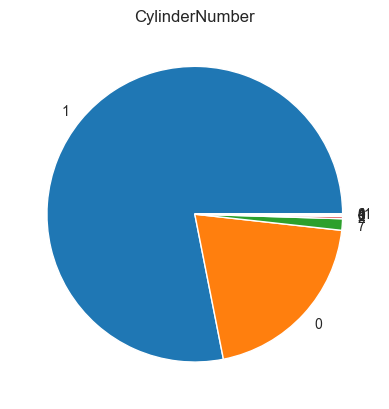

In [246]:
plt.pie(
    df.CylinderNumber.value_counts().values,
    labels=df.CylinderNumber.value_counts().index
)
plt.title("CylinderNumber")
plt.show()

Заметим, что здесь есть 2 категории, которые занимают огромную долю среди всех значений: 0 и 1. Оставим данные, содержащие только записи с данными значениями этого показателя.

In [247]:
df = df[(df.CylinderNumber == 0) | (df.CylinderNumber == 1)]

Далее рассмотрим распределение цветов кузова автомобилей.

## 2.8 Проверка выбросов Color

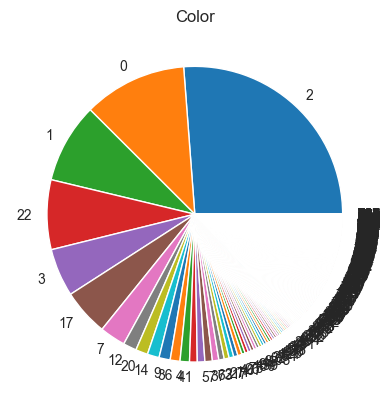

In [248]:
plt.pie(
    df.Color.value_counts().values,
    labels=df.Color.value_counts().index
)
plt.title("Color")
plt.show()

Увидим, что здесь у нас встречается огромное количество различных вариантов цветов, а именно:

In [249]:
len(df.Color.unique())

685

Как и в случае с маркой автомобиля, оставим лишь те значения, которые встречаются более 100 раз

In [250]:
relevant_values = []
for i in range(len(df.Color.unique())):
    if len(df[df.Color == df.Color.unique()[i]]) > 100:
        relevant_values.append(df.Color.unique()[i])

df = df[df.Color.isin(relevant_values)]

## 2.9 Проверка выбросов ValveConfiguration
Перейдем к оценке расположения клапанов двигателя. Для этого вновь воспользуемся столбчатой диаграммой.

5

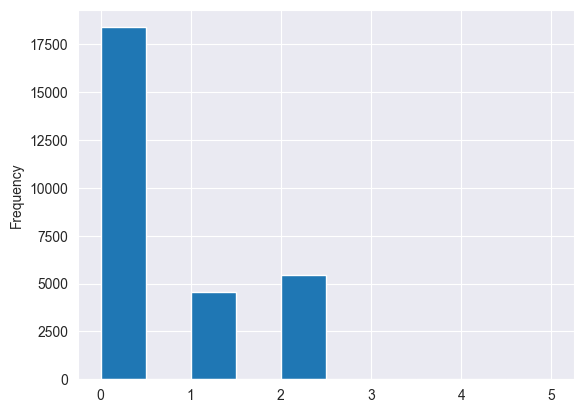

In [251]:
df.ValveConfiguration.plot(kind="hist")
len(df.ValveConfiguration.unique())

Видим, что из 6 возможных уникальных значений на графике видны только первые 3, а значит, доля остальных настолько мала, что записи с этими значениями лучше принять за выбросы и удалить. 

In [252]:
df = df[df.ValveConfiguration < 3]

## 2.10 Проверка выбросов TopSpeed
Далее оценим на выбросы столбец с максимальной достижимой скоростью автомобиля.

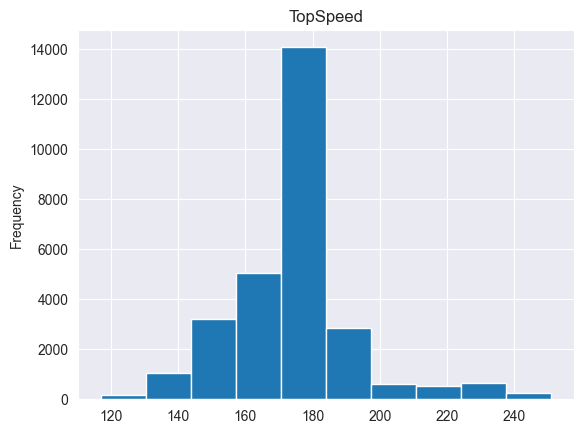

In [253]:
df.TopSpeed.plot(kind="hist")
plt.title("TopSpeed")
plt.show()

Оставим в нашем датасете лишь те записи, где максимальная скорость находится в диапазоне между 140 и 200 км/час 

In [254]:
df = df[(df.TopSpeed >= 140) & (df.TopSpeed <= 200)]

## 2.11 Проверка выбросов TurboCharger
Наконец проверим столбец с наличием турбонаддува на наличие выбросов.

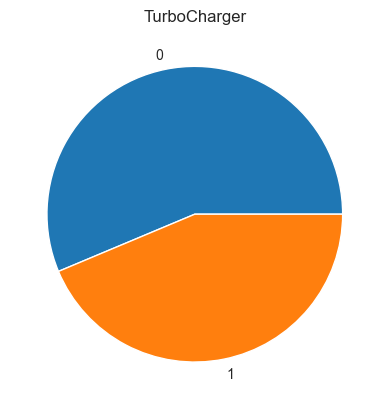

(25812, 11)

In [255]:
plt.pie(
    df.TurboCharger.value_counts().values,
    labels=df.TurboCharger.value_counts().index
)
plt.title("TurboCharger")
plt.show()
df.shape

Здесь присутствуют только два вида значений: 0 и 1, а значит, выбросов не обнаружено.

Таким образом, после очистки датасета от выбросов у нас осталось 25812 записей, что по-прежнему позволяет нам работать с моделями. На этом предобработка данных завершена.

# Этап №3. Применение моделей
Для начала работы с моделями необходимо разбить данные на 2 группы: те, по которым будет выдвигаться решение, и те, с которыми это решение будет сравниваться. В нашем случае во вторую группу попадает колонка TurboCharger, а все остальные колонки - в первую группу.
Обозначим первую группу за x, а вторую - за y.

In [256]:
x = df[[
    'BodyType',
    'ModelYear',
    'TransmissionType',
    'DriveType',
    'FuelType',
    'Brand',
    'CylinderNumber',
    'Color',
    'ValveConfiguration',
    'TopSpeed',
]]

y = df[[
    'TurboCharger'
]]

Теперь разделим данные на наборы для обучения и теста. Для обучения будем использовать 75% данных, для тестов - 25%. За это разделение у нас отвечает параметр test_size, который задается как коэффициент и в данном случае равен 0.25. Также сразу данные необходимо стандартизировать под размеры датафрейма.

In [257]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True)

standardise = StandardScaler()
x_train_scale = standardise.fit_transform(x_train)
x_train_scale = pd.DataFrame(x_train_scale)
x_test_scale = standardise.transform(x_test)
x_test_scale = pd.DataFrame(x_test_scale)

## 3.1 Метод k ближайших соседей
Первой моделью используем метод k ближайших соседей. KNN или K-ближайших соседей — это алгоритм классификации, который основывается на близости объектов. Он определяет класс нового объекта, анализируя ближайших к нему соседей и выбирая наиболее часто встречающийся класс среди этих соседей.

Подберем оптимальный гиперпараметр, а именно, количество соседей k с помощью простого перебора, используя встроенную функцию range, подставляя предлагаемые значения в модель.

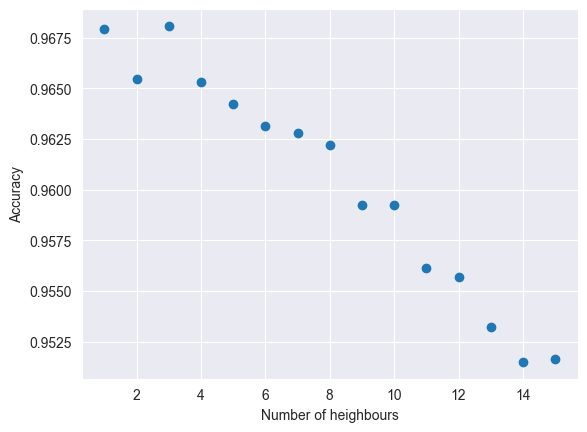

In [258]:
accuracy = []
num_neigh = []

for i in range(1, 16):
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(x_train_scale, np.ravel(y_train, order='C'))
    accuracy.append(KNN.score(x_test_scale, y_test))
    num_neigh += [i]

plt.scatter(num_neigh, accuracy)
plt.xlabel('Number of heighbours')
plt.ylabel('Accuracy')
plt.show();

Для того чтобы модель k ближайших соседей работала оптимально и была готова к переобучению, необходимо взять как можно меньшее количество соседей. Поэтому мы остановимся на значении 3, при котором у нас достигается наибольшая точность (Accuracy).
Создадим модель KNN с подобранным количеством соседей и подгоним её под размеры наших данных.

In [259]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN = KNN.fit(x_test_scale, np.ravel(y_test, order='C'))

С помощью данной модели предскажем наличие турбонаддува и засечём время, потраченное на работу.

In [260]:
start_time = time.time()
predict_TurboCharger_KNN = KNN.predict(x_test_scale)
end_time = time.time()

Соберём полученные данные в удобный вид: словарь, в котором будут значения:
- реальное значение TurboCharger из датасета
- предсказанное значение
- булево значение совпадения двух вышеперечисленных показателей

In [261]:
result_KNN = {"RealTurboCharger": list(y_test.TurboCharger), "PredictTurboCharger": list(predict_TurboCharger_KNN)}
result_KNN = pd.DataFrame(result_KNN)
result_KNN["is_True"] = result_KNN["RealTurboCharger"] == result_KNN["PredictTurboCharger"]

result_KNN.head()

,RealTurboCharger,PredictTurboCharger,is_True
0,0,0,True
1,1,1,True
2,0,0,True
3,1,1,True
4,0,0,True


Далее рассчитаем время работы метода KNN и точность его работы при обучении и тестировании. На эти данные мы посмотрим позже при сравнении работы разных моделей.

In [262]:
KNN_time = end_time - start_time
KNN_train_accuracy = max(accuracy)
KNN_test_accuracy = sum(result_KNN["is_True"]) / len(result_KNN["is_True"])

## 3.2 Метод решающих деревьев
Структура дерева представляет собой «листья» и «ветки». На рёбрах («ветках») дерева решения записаны признаки, от которых зависит целевая функция, в «листьях» записаны значения целевой функции, а в остальных узлах — признаки, по которым различаются случаи. Чтобы классифицировать новый случай, надо спуститься по дереву до листа и выдать соответствующее значение.

Далее подберем гиперпараметр (глубину) для метода решающих деревьев аналогично предыдущему методу - с помощью перебора.

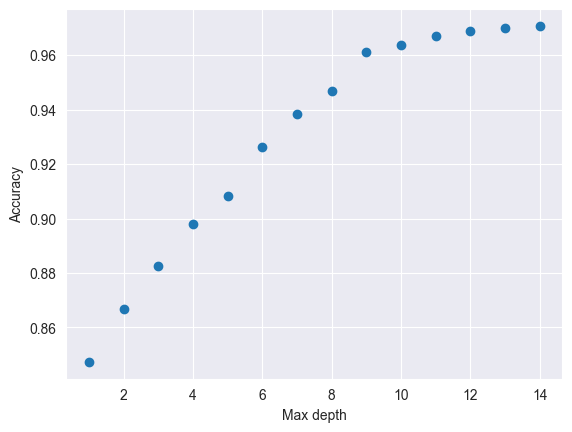

In [263]:
accuracy = []
depth = []

for i in range(1, 15):
    DT = DecisionTreeClassifier(max_depth=i)
    DT.fit(x_train_scale, y_train)
    accuracy.append(DT.score(x_test_scale, y_test))
    depth.append(i)

plt.scatter(depth, accuracy)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.show();

В данном случае наоборот - чем больше число глубины, тем легче потом будет переобучать модель. Поэтому остановимся на числе 13.
По аналогии с предыдущих методов создадим модель, предскажем с её помощью наличие турбонаддува и соберём данные в аналогичный словарь, который далее будет приведён к типу DataFrame для удобной работы. 

In [264]:
DT = DecisionTreeClassifier(max_depth=13)
DT = DT.fit(x_test_scale, y_test)

start_time = time.time()
predict_TurboCharger_DT = DT.predict(x_test_scale)
end_time = time.time()

result_DT = {"RealTurboCharger": list(y_test.TurboCharger), "PredictTurboCharger": list(predict_TurboCharger_DT)}
result_DT = pd.DataFrame(result_DT)
result_DT["is_True"] = result_DT["RealTurboCharger"] == result_DT["PredictTurboCharger"]

result_DT.head()

,RealTurboCharger,PredictTurboCharger,is_True
0,0,0,True
1,1,1,True
2,0,0,True
3,1,1,True
4,0,0,True


Также рассчитаем время работы и показатели Accuracy для обучения и тестирования с помощью данной модели.

In [265]:
DT_time = end_time - start_time
DT_train_accuracy = max(accuracy)
DT_test_accuracy = sum(result_DT["is_True"]) / len(result_DT["is_True"])

## 3.3 Метод случайных лесов
Лес состоит из ансамбля решающих деревьев. Лес создает деревья решений для случайно выбранных семплов данных, получает прогноз от каждого дерева и выбирает наилучшее решение посредством голосования.

Для него подберём гиперпараметры - n_estimators и max_features - с помощью GridSearchCV.
n_estimators - количество решающих деревьев, которые будут использоваться в работе леса, max_features - максимальное количество признаков, которые алгоритм может использовать для поиска лучшего разбиения в каждом узле дерева 

In [266]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid)
grid_search.fit(x_train, np.ravel(y_train, order='C'))
grid_search.best_params_

{'max_features': None, 'n_estimators': 100}

После подбора гиперпараметров инициализируем лес с полученными значениями. Гиперпараметр максимальной глубины возьмем подобранный ранее для метода решающих деревьев. 

In [267]:
RF = RandomForestClassifier(n_estimators=150, max_features=None, max_depth=13)
RF.fit(x_train, np.ravel(y_train, order='C'))

RandomForestClassifier(max_depth=13, max_features=None, n_estimators=150)

Как и в ранее представленных методах, спрогнозируем наличие турбонаддува, соберём данные в удобный вид и рассчитаем необходимые показатели. Однако здесь для расчёта Accuracy будем использовать метод accuracy_score из библиотеки scikit-learn.

In [268]:
RF_train = RF.predict(x_train)

start_time = time.time()
predict_TurboCharger_RF = RF.predict(x_test)
end_time = time.time()

result_RF = {"RealTurboCharger": list(y_test.TurboCharger), "PredictTurboCharger": list(predict_TurboCharger_RF)}
result_RF = pd.DataFrame(result_RF)
result_RF["is_True"] = result_RF["RealTurboCharger"] == result_RF["PredictTurboCharger"]

RF_time = end_time - start_time
RF_train_accuracy = accuracy_score(y_train, RF_train)
RF_test_accuracy = accuracy_score(y_test, predict_TurboCharger_RF)

result_RF.head()

,RealTurboCharger,PredictTurboCharger,is_True
0,0,0,True
1,1,1,True
2,0,0,True
3,1,1,True
4,0,0,True


## 3.4 Метод градиентного бустинга
Данный метод является продвинутым методом машинного обучения. Он использует несколько обычных моделей, чаще всего - решающих деревьев, и делает так, чтобы решение каждой последующей модели сводило ошибки предыдущей к минимуму. Также с помощью GridSearchCV подберём наилучшие гиперпараметры: n_estimators (количество используемых в ансамбле "решаторов") и learning_rate(шаг, на который каждое новое добавляемое к ансамблю дерево корректирует ошибки предыдущих моделей). 

In [269]:
param_grid = {
    "n_estimators": [5, 50, 250, 500],
    "learning_rate": [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5)
grid_search.fit(x_train, np.ravel(y_train, order='C'))
grid_search.best_params_

{'learning_rate': 1, 'n_estimators': 500}

Как и в прошлом случае, инициализируем модель градиентного бустинга с подобранными гиперпараметрами.

In [270]:
GBC = GradientBoostingClassifier(n_estimators=500, learning_rate=1)
GBC.fit(x_train, np.ravel(y_train, order='C'))

GradientBoostingClassifier(learning_rate=1, n_estimators=500)

Уже знакомым способом реализуем все необходимые шаги для этой модели:
1. Тренировка модели
2. Предсказание результата для тестовых данных с измерением затраченного времени
3. Сбор данных в DataFrame для удобства последующей обработки
4. Расчёт метрик

In [271]:
GBC_train = GBC.predict(x_train)

start_time = time.time()
predict_TurboCharger_GBC = GBC.predict(x_test)
end_time = time.time()

result_GBC = {"RealTurboCharger": list(y_test.TurboCharger), "PredictTurboCharger": list(predict_TurboCharger_GBC)}
result_GBC = pd.DataFrame(result_GBC)
result_GBC["is_True"] = result_GBC["RealTurboCharger"] == result_GBC["PredictTurboCharger"]

GBC_time = end_time - start_time
GBC_train_accuracy = accuracy_score(y_train, GBC_train)
GBC_test_accuracy = accuracy_score(y_test, predict_TurboCharger_GBC)

result_GBC.head()

,RealTurboCharger,PredictTurboCharger,is_True
0,0,0,True
1,1,1,True
2,0,0,True
3,1,1,True
4,0,0,True


# Этап №4. Визуализация и конкурентный анализ моделей
Самым важным этапом работы с данными является анализ полученных результатов. С помощью визуализации с использованием matplotlib и seaborn мы подробно рассмотрим, где какая модель сработала лучше, а где - хуже. 
## 4.1 Матрицы ошибок
Матрицы ошибок представляют собой график показывающий, где модель сработала верно и предсказала верный ответ, а где допустила ошибку 1-го или 2-го рода: неверно обозначила 1 за 0 или 0 за 1.
Для построения матриц ошибок мы будем использовать кросс-таблицы (crosstab) из библиотеки pandas, позволяющие соотносить данные из двух источников: реальные данные из датасета и полученные с помощью работы модели. Далее будет произведена визуализация с помощью тепловых карт (heatmap) из библиотеки seaborn.
### 4.1.1 Матрица ошибок KNN

Матрица ошибок для KNN


<Axes: xlabel='PredictTurboCharger', ylabel='RealTurboCharger'>

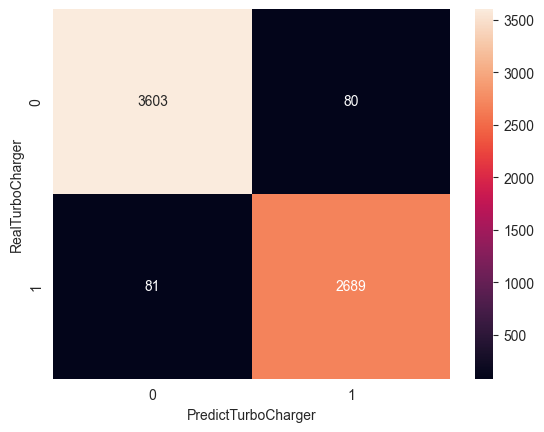

In [272]:
freq = pd.crosstab(result_KNN["RealTurboCharger"], result_KNN["PredictTurboCharger"])
print("Матрица ошибок для KNN")
sns.heatmap(freq, annot=True, fmt="d")

### 4.1.2 Матрица ошибок DT

Матрица ошибок для решающих деревьев


<Axes: xlabel='PredictTurboCharger', ylabel='RealTurboCharger'>

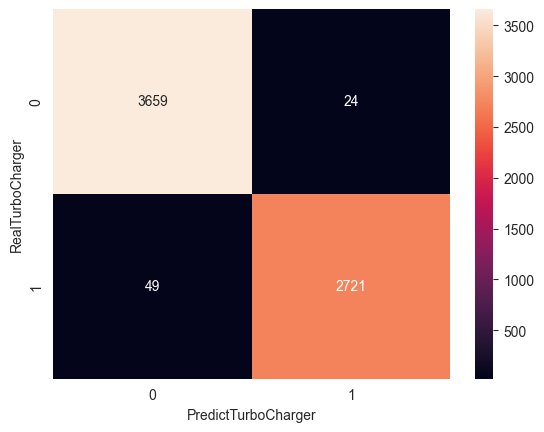

In [273]:
freq = pd.crosstab(result_DT["RealTurboCharger"], result_DT["PredictTurboCharger"])
print("Матрица ошибок для решающих деревьев")
sns.heatmap(freq, annot=True, fmt="d")

### 4.1.3 Матрица ошибок RF

Матрица ошибок для случайных лесов


<Axes: xlabel='PredictTurboCharger', ylabel='RealTurboCharger'>

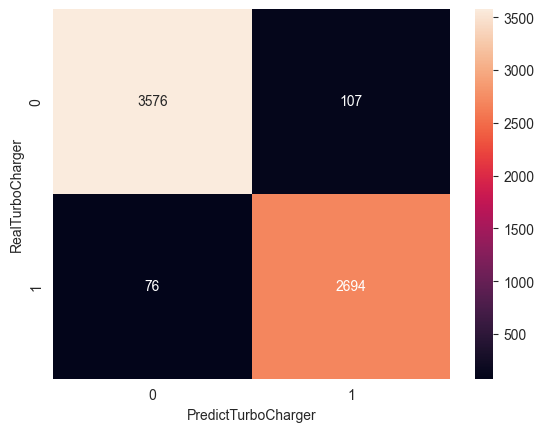

In [274]:
freq = pd.crosstab(result_RF["RealTurboCharger"], result_RF["PredictTurboCharger"])
print("Матрица ошибок для случайных лесов")
sns.heatmap(freq, annot=True, fmt="d")

### 4.1.4 Матрица ошибок GBC

Матрица ошибок для градиентного бустинга


<Axes: xlabel='PredictTurboCharger', ylabel='RealTurboCharger'>

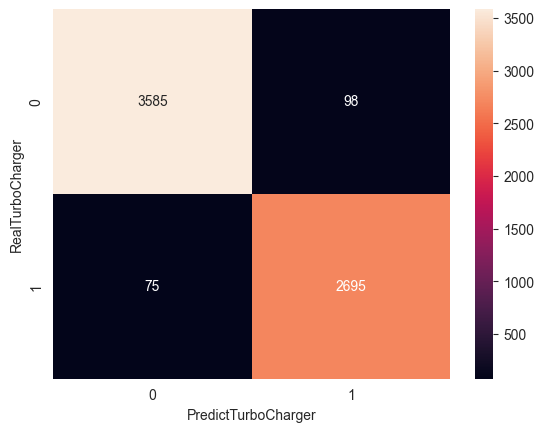

In [275]:
freq = pd.crosstab(result_GBC["RealTurboCharger"], result_GBC["PredictTurboCharger"])
print("Матрица ошибок для градиентного бустинга")
sns.heatmap(freq, annot=True, fmt="d")

## 4.2 Сравнение метрик
После работы всех моделей у нас сохранено множество данных о результатах их работ. Для начала сравним все модели по скорости их работы. Для этого соберём список с переменными, хранящими данные о времени работы для каждой из моделей, а затем этот список преобразуем в DataFrame и построим линейный график.

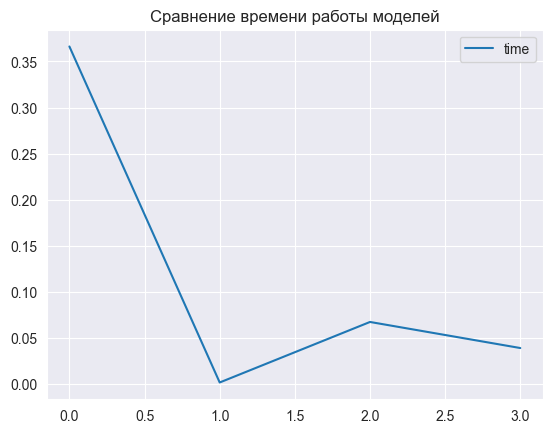

[0.3661766052246094,
 0.0020139217376708984,
 0.06760263442993164,
 0.039342403411865234]

In [276]:
time_list = [KNN_time, DT_time, RF_time, GBC_time]
time_df = pd.DataFrame(
    {
        "time": time_list
    }
)

time_df.plot()
plt.title("Сравнение времени работы моделей")
plt.show()
time_list

Видим, что метод KNN является самым медленным: на его работу потребовалось более 0,6 секунды, в то время как среди других моделей ни одна не использовала более 0,07 секунд. Быстрее всех сработала модель решающих деревьев: при разных попытках запуска - от 130 до 180 раз быстрее, чем KNN.

Далее рассчитаем несколько дополнительных метрик для каждой из моделей:
-  точность (precision)
- полноту (recall)
- метрику f1

А также добавим сюда уже рассчитанные точности (accuracy) для каждой из моделей при обучении и тестировании. После чего построим сводный график и посмотрим, какая модель обладает наилучшими показателями.

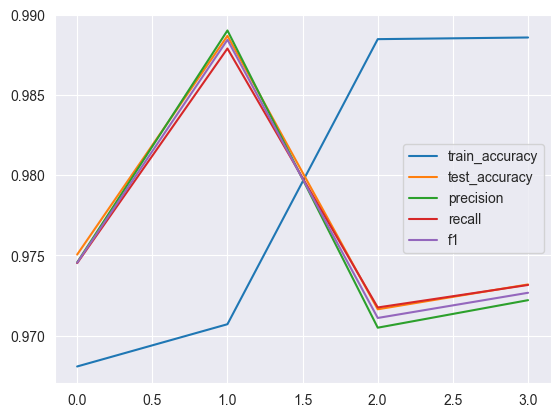

,model,train_accuracy,test_accuracy,precision,recall,f1
0,KNN,0.968077,0.975050,0.974561,0.974518,0.974540
1,DT,0.970711,0.988687,0.989021,0.987897,0.988443
2,RF,0.988481,0.971641,0.970494,0.971755,0.971101
3,GBC,0.988584,0.973191,0.972210,0.973158,0.972671


In [277]:
train_accuracy_list = [
    KNN_train_accuracy,
    DT_train_accuracy,
    RF_train_accuracy,
    GBC_train_accuracy
]

test_accuracy_list = [
    KNN_test_accuracy,
    DT_test_accuracy,
    RF_test_accuracy,
    GBC_test_accuracy
]

precision_list = [
    precision_score(y_test, predict_TurboCharger_KNN, average="macro"),
    precision_score(y_test, predict_TurboCharger_DT, average="macro"),
    precision_score(y_test, predict_TurboCharger_RF, average="macro"),
    precision_score(y_test, predict_TurboCharger_GBC, average="macro")
]
recall_list = [
    recall_score(y_test, predict_TurboCharger_KNN, average="macro"),
    recall_score(y_test, predict_TurboCharger_DT, average="macro"),
    recall_score(y_test, predict_TurboCharger_RF, average="macro"),
    recall_score(y_test, predict_TurboCharger_GBC, average="macro"),
]

f1_list = [
    f1_score(y_test, predict_TurboCharger_KNN, average="macro"),
    f1_score(y_test, predict_TurboCharger_DT, average="macro"),
    f1_score(y_test, predict_TurboCharger_RF, average="macro"),
    f1_score(y_test, predict_TurboCharger_GBC, average="macro")
]

metrics = {
    "model": ["KNN", "DT", "RF", "GBC"],
    "train_accuracy": train_accuracy_list,
    "test_accuracy": test_accuracy_list,
    "precision": precision_list,
    "recall": recall_list,
    "f1": f1_list
}
metrics = pd.DataFrame(metrics)

metrics.plot()
plt.show()
metrics

Вывод: Мы видим, что все модели отлично справились с поставленной задачей, и ни один из показателей не опускается ниже значения в 0.969701. Все показатели кроме точности при обучении у моделей изменяются, можно сказать, по одним и тем же законам. Метод решающих деревьев, несмотря на то, что работает быстрее всех, показал наихудший результат при обучении моделе, в то время как ансамбль таких деревьев - случайный лес - наилучший. Однако по всем остальным показателям решающие деревья действительно превосходят другие модели в результатах, хоть и незначительно. 

Также по итогам проведённой работы можно предположить, что гиперпараметры для случайных лесов и градиентного бустинга всё-таки были подобраны не наилучшим из возможных способов, так как простейший метод k ближайших соседей иногда показывает показатели лучше, чем два этих более сложных метода.

P.S. Описанные на этапе №4 результаты их соотношение между моделями может меняться при каждом из запусков программы, однако общая тенденция остается неизменной: KNN - самый медленный, DT - наиболее быстрое и эффективное решение).